# Amoebas, Amoebas!

At time zero there is one amoeba in a petri dish.  It splits with probability ps.  With probability 1-ps it dies without splitting, and its entire line (only itself at this point) is eliminated.  If it splits, on the other hand, it produces two amoeba that both live to next period (period 1.) At period 1, if there are any amoeba, each has a probability ps of splitting and 1-ps of dying without splitting.  This occurs again and again as long as there are amoeba in the dish; at evenly spaced intervals, if there are any amoeba left, each one splits and survives with probability ps and dies without splitting with probability 1-ps.  What is the probability that the amoeba line continues forever, if ps = 3/4? if ps = 1/2? if ps = 9/10?

### Analytic solution:

According to conditional probability, 

    Prob(line lives forever) = Prob(line lives forever|first amoeba splits) x Prob(first amoeba splits) 
                               + Prob(line lives forever|first amoeba dies) x Prob(first amoeba dies)
                             = Prob(line lives forever|first amoeba splits) x Prob(first amoeba splits) + 0,

since the line cannot live forever if the first amoeba dies.  Let ps be the probability of any one amoeba splitting at any time t, and let P be the probability of the entire amoeba line surviving forever.  Give that the first amoeba successfully splits, the line will continue to infinity if at least one of the offspring produces an infinite line.  But each one of the offspring will have an identical likelihood of producing an infinite line as the first one did; i.e., each one produces an infinite line with probability P.  The only way the line would stop in finite time is if _**both**_ of the two offspring terminates in finite time.  Since these are independent events, this happens with probability (1-P)^2.  Therefore, the probability that at least one of the offspring lives forever, given the first amoeba splits, is 1-(1-P)^2.

Therefore by the above equation,

    P = [1 - (1 - P)^2] x ps
    P = [1 - 1 + 2P - P^2] x ps
    P = [2P - P^2] x ps
    P = [2 - P] x P x ps  
        
One solution to this equation is P = 0.  It may be that the line has no chance of surviving to infinity.  On the other hand if we assume P > 0, we get
   
    1 = [2 - P] x ps
    1/ps = 2 - P
    P = 2 - 1/ps
    
Which is an upward-sloping graph, implying that as ps increases, for ps > 0.5, P increases as well.  


Notice that ps = 0.5 implies P = 0!  If every amoeba has exactly a 50% chance of surviving and splitting, then the line has 0 chance of continuing forever. Since probability is always non-negative, for ps less than 0.5, we must have P = 0.  We therefore have

    P = 0          for  0 <= ps <= 1/2
    P = 2 - 1/ps   for  1/2 < ps <= 1


* p=0.75 => P = 2-4/3 = 2/3 ~ 0.667
* p=0.9 => P = 2-10/9 = 8/9 ~ 0.889 

 

Ok, so can we simulate this?

## Simulation

The simulation strategy is to create many amoeba lines, and see what proportion of the lines are still surviving and dividing after a while.  If they die off, their count goes to zero.  We therefore want to count the number of lines with positive numbers remaining after some number of periods, and divide by the total number of lines.   

At each period t, some proportion of amoeba split and survive.  This is the same problem as flipping a biased coin N times and counting the number of times it comes up heads, where N is the total amoeba count at time t, and p is the probability of splitting.  Every time the coin comes up heads, we add another amoeba to the count.  Every time it comes up tails, we remove one as it dies off without splitting.  The probability distribution we need is the Binomial distribution.  We draw a number from the distribution Binomial(p, count[t]), where p is the probability of splitting and count[t] is the total amoeba count for this particular line at time t. Call that number "num_that_split." If "num_that_split" survive and split, then "num_that_dont" = count[t] - "num_that_split." We add "num_that_split" to count[t], but we also subtract "num_that_dont" to get count[t+1].
        
        num_that_split = np.random.binomial(counts[t], prob_split)
        num_that_dont = count[t] - num_that_split
        count[t+1] = count[t] + num_that_split - num_that_dont

If you use the Bernoulli distribution instead of the Binomial, then you will have to draw again and again from the set {-1,1} and add the result to the count each time.  This can get computationally expensive as the lines grow, as you're asking for count[t] random numbers for every time step, for every line.  The binomial is already designed to deal with this, and it only requires one draw at each time step for each line.

In [57]:
import pandas
import seaborn
%pylab inline 

seaborn.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [58]:
np.random.seed(1234)

def get_line_survival(prob_split, time_periods=50, amoeba_lines=1000, verbose=False, log_plot=False):
    #initialize a dictionary to hold counts over time for each amoeba line. 
    time_periods = int(time_periods)
    amoeba_lines_dic = {}
    #iterate through the amoeba lines, creating a simulation of splits with probability prob_split and deaths with prob. 1-prob_split
    for line in range(amoeba_lines):
        #initialize the count to zero, all periods, but 1 for the first period, representing the first amoeba.
        counts = np.zeros(time_periods + 1)
        counts = counts.astype(int)
        counts[0] = 1
        #run the simulation for the line for time_periods periods.
        for t in range(time_periods):
            num_that_split = np.random.binomial(counts[t], prob_split)
            num_that_dont = counts[t] - num_that_split
            if (counts[t] + num_that_split - num_that_dont) < 0:
                counts[t+1] = counts[t]
            else:
                counts[t+1] = counts[t] + num_that_split - num_that_dont
        #Store the results in the dictionary.
        amoeba_lines_dic['line'+str(line)] = counts
    #Create a dataframe for analytics on the simulations
    amoeba_df = pandas.DataFrame(amoeba_lines_dic)
    if verbose:
        print(amoeba_df)
    to_plot = amoeba_df.columns
    if amoeba_lines > 15:
        print("Too many lines, plotting 15 random lines.")
        to_plot = np.random.choice(to_plot, 15, replace=False, )
    for i,col in enumerate(to_plot):
        x = range(len(amoeba_df[col]+1))
        y = amoeba_df[col]
        plt.plot(x,y,label=col,c=plt.cm.rainbow(i*15))
    if log_plot:
        plt.semilogx()
        plt.semilogy()
    plt.legend()
    #Get the last row, which represents the final counts for each line at the end of the simulation.
    last_period = amoeba_df.iloc[time_periods]
    #Find the percentage of lines that have a positive number of amoeba at the end of the simulation.
    lines_remaining = 1.0*last_period[last_period>0].count()/last_period.count()
    plt.title(f"Prob of split: {prob_split}, "
              f"Empirical prob for {amoeba_lines} lines at {time_periods} steps: {lines_remaining*100.0:.1f}, " 
              f"Predited prob at ∞: {max(2-1/prob_split, 0)*100.0:.1f}.")
    plt.xlabel("Time Steps")
    plt.ylabel("Number of Amoebas")
    return lines_remaining

    line0  line1  line2  line3  line4  line5  line6  line7  line8  line9
0       1      1      1      1      1      1      1      1      1      1
1       2      2      2      0      2      2      2      0      2      2
2       2      2      2      0      4      2      2      0      2      2
3       2      2      4      0      8      2      2      0      0      2
4       2      2      6      0     10      4      4      0      0      0
5       2      4      4      0     12      4      6      0      0      0
6       4      6      4      0     16      2     12      0      0      0
7       6      8      6      0     28      2     16      0      0      0
8       6     16      6      0     36      0     12      0      0      0
9       4     18     10      0     50      0     20      0      0      0
10      2     18     12      0     66      0     30      0      0      0


0.5

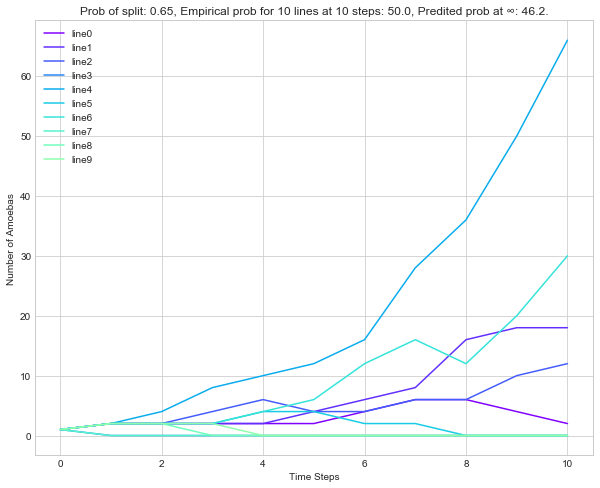

In [59]:
figsize(10,8)
get_line_survival(0.65, time_periods=1e1,amoeba_lines=10,verbose=True)

Too many lines, plotting 15 random lines.


0.043999999999999997

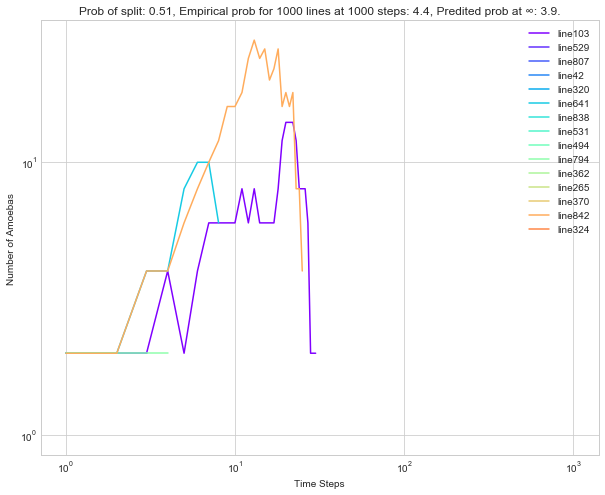

In [60]:
get_line_survival(0.51, time_periods=1000, log_plot=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in long_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in long_scalars


Too many lines, plotting 15 random lines.


0.67800000000000005

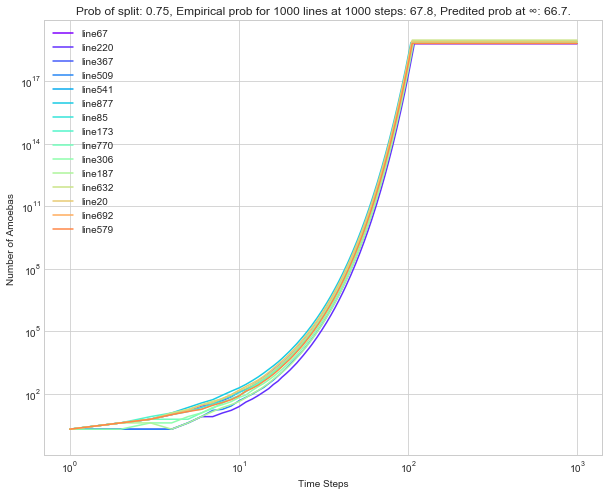

In [61]:
get_line_survival(0.75, time_periods=1000, log_plot=True)

In [63]:
10**30

1000000000000000000000000000000

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in long_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in long_scalars


Too many lines, plotting 15 random lines.


0.879

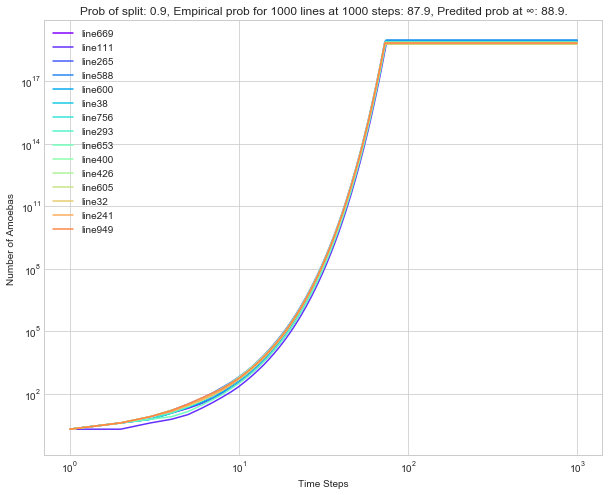

In [54]:
get_line_survival(0.9, time_periods=1000, log_plot=True)

Too many lines, plotting 15 random lines.


0.001

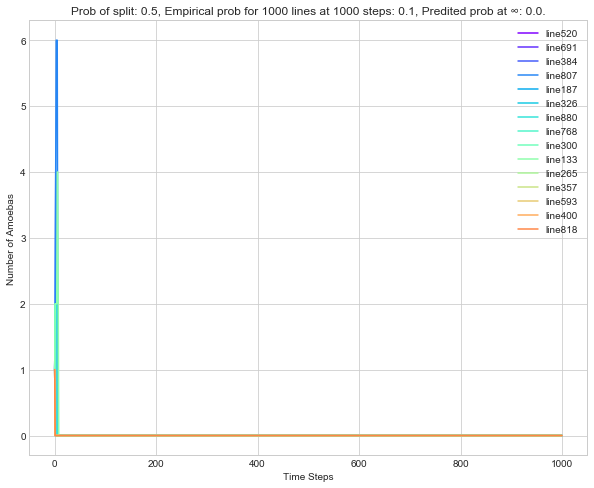

In [44]:
get_line_survival(0.5, time_periods=1000)

Notice that the numbers match the above analytic solution down to the thousandth's place.  for p=0.5, Only 1 of the 1000 lines survived until t=5000, but this line is doomed, by the analytic solution above!

For kicks, let's see if ps=0.25 also drives the survival rate to zero.

Too many lines, plotting 15 random lines.


0.0

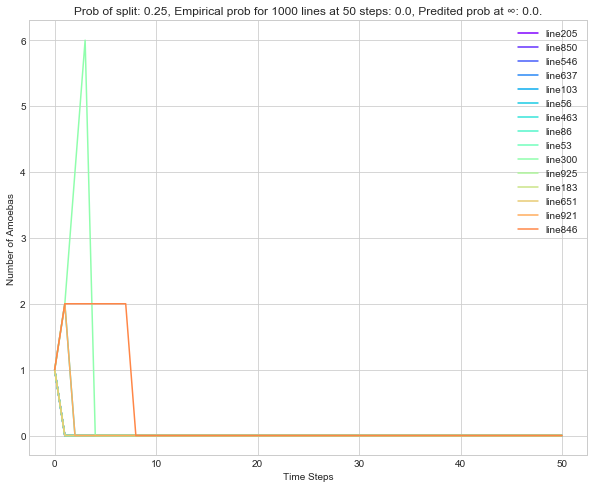

In [41]:
get_line_survival(0.25)

If ps = 5/6, we get P = 2 - 6/5 = 4/5 = 0.8

Too many lines, plotting 15 random lines.


0.85999999999999999

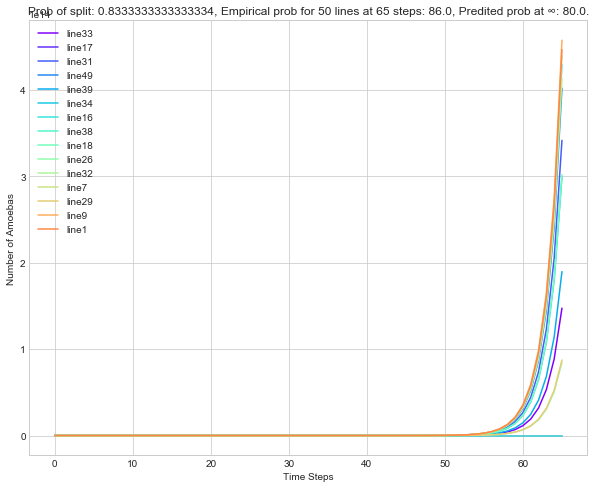

In [42]:
get_line_survival(1.0*5/6, amoeba_lines=50,time_periods=65)